In [1]:
import csv
import numpy as np
import ROOT as rt
import os
from glob import glob
import math

Welcome to JupyROOT 6.14/04


In [2]:
def frange(start, stop, step):
    i = start
    ll = []
    while i < stop:
        ll.append(i)
        i += step
    return ll

In [19]:
def gain_xtalk(file,th):
    f = open(path+file)
    content = csv.reader(f)
    amp_factor = 10
    Resistance = 50
    Amp_x_R = amp_factor * Resistance
    x = []
    y = []
    for r in content:
        x.append(1e12*float(r[0]) / Amp_x_R) # x has unit pC now
        y.append(float(r[1]))

    h = rt.TH1F('h', 'h', int(len(x)), x[0], x[-1])
    h.SetXTitle('Charge [pC]')
    h.SetYTitle('Events / {:1.1e} pC'.format(h.GetBinWidth(1)))
    for i in range(len(x)):
        h.SetBinContent(i+1, y[i])
    peak_sigma = 0.01
    SS = rt.TSpectrum()
    n_pks = SS.Search(h, 0.01, "", 0.01)
    x_pos = SS.GetPositionX()
    y_pos = SS.GetPositionY()


    gr_gain = rt.TGraphErrors(n_pks)


    Ch2N = 1.0e-12/1.6e-19
    peak_height_position = []
    pos_err = []
    h_poiss = rt.TH1F('h_poiss', 'Measured probability of number of photo electrons', n_pks, -0.5, n_pks - 0.5)
    # mean = []
    # sig = []

    for i in range(n_pks):
        n_pk = h.FindBin(x_pos[i])

        thr = th * h.GetBinContent(n_pk)
        n_low = n_pk
        while h.GetBinContent(n_low) > thr:
            n_low -= 1
        x_low = h.GetBinCenter(n_low)    


        n_up = n_pk
        while h.GetBinContent(n_up) > thr:
            n_up += 1
        x_up = h.GetBinCenter(n_up)

        r = h.Fit('gaus', 'LRSQ+', '', x_low, x_up)
        r = r.Get()
    #     mean.append(r.Parameter(1))
    #     sig.append(r.Parameter(2))

#         print ("peak number: "+ str(i)+', prob: '+str(r.Prob()))

        integral = r.Parameter(0) * np.sqrt(2*np.pi) * r.Parameter(2) / h.GetBinWidth(1)
        peak_height_position.append((integral,r.Parameter(1)))
        pos_err.append(r.ParError(1))
        h_poiss.SetBinContent(i+1, integral)
        d_int = integral * rt.TMath.Hypot(r.ParError(0)/r.Parameter(0), r.ParError(2)/r.Parameter(2))
        h_poiss.SetBinError(i+1, d_int)
#         print(r.Parameter(1))


    print 'p-val = {:.3f}'.format(r.Prob())
    
    #crosstalk stuff
    n = 4
    peak_height_position.sort(key=lambda tup: tup[1])
    events = sum(x[0] for x in peak_height_position)
    mu = -np.log(peak_height_position[0][0]/events)
    epsilon = 1- peak_height_position[1][0]/events/(mu*math.exp(-mu))
    crosstalk = epsilon + (3*n-3)/(2*n)*epsilon**2
    
    #gain fit
    for i in range(len(peak_height_position)):
        gr_gain.SetPoint(int(i), float(i), peak_height_position[i][1]*Ch2N)
        gr_gain.SetPointError(int(i), 0, pos_err[i]*Ch2N)
    r = gr_gain.Fit('pol1', 'S')
    r = r.Get()
    gain = r.Parameter(1)
    gain_err = r.ParError(1)
    print('gain',gain)
    return int(gain),int(gain_err), epsilon, crosstalk

In [34]:
#get all files in f_list
path_list = []
# path_list.append('../data/181027_single_photon_changingOV_sensL_Laser90_ND1_miniAmp/J_33_5/')
# path_list.append('../data/181027_single_photon_changingOV_sensL_Laser90_ND1_miniAmp/J_33_4/')
# # path_list.append('../data/181027_single_photon_changingOV_sensL_Laser90_ND1_miniAmp/J_33_3/')
# # path_list.append('../data/181027_single_photon_changingOV_sensL_Laser90_ND1_miniAmp/J_33_2/')
# path_list.append('../data/18_10_29_HamSurfaceMount_SinglePhoton/')
path_list.append('../data/18_11_05_single_photon_sensl_boards/J_44_35_1/')

# path_list.append('../data/18_10_24_sensL_J33_singlephoton/J_33_3/')
# path_list.append('../data/18_10_24_sensL_J33_singlephoton/J_33_2/')
ov = frange(28,30.5,0.5) #over voltage
# ov = frange(56.5,59.5,0.5)
gain = rt.TMultiGraph()
xtalk = rt.TMultiGraph()
gain_graph_list = []
xtalk_graph_list = []
epsilon_graph_list = []
for i in range(len(path_list)):
    path = path_list[i]
    gain_graph_list.append(rt.TGraphErrors())
    xtalk_graph_list.append(rt.TGraphErrors())
    epsilon_graph_list.append(rt.TGraphErrors())



In [35]:
for i in range(len(path_list)):
    path = path_list[i]
    f_list = os.listdir(path)
    for file_name in f_list:
        if not 'miniAmp' in file_name:
            f_list.remove(file_name)
        if 'broke' in file_name:
            f_list.remove(file_name)

    f_list = sorted(f_list)
    print f_list
    for j in range(len(f_list)):
        th = 0.8
#         if j == 0:
#             th = 0.9
        g, gain_err,epsilon,crosstalk = gain_xtalk(f_list[j],th)
        gain_graph_list[i].SetPoint(j, ov[j],g)
        gain_graph_list[i].SetPointError(j,0,gain_err)
#         print(ov[j],g)
        xtalk_graph_list[i].SetPoint(j, ov[j],epsilon*100)
        epsilon_graph_list[i].SetPoint(j, ov[j],epsilon)
#         if i ==1 and j == 1:
#             gain_graph_list[i].SetPoint(j, ov[j],37911)
for i in range(len(path_list)):
    gain.Add(gain_graph_list[i])    
    xtalk.Add(xtalk_graph_list[i])
#     epsilon.Add(epsilon_graph_list[0])



['sensl_J_44_35_1_OV28V_LaserTune95p6_ND1_miniAmp_gate15ns.csv', 'sensl_J_44_35_1_OV28p5V_LaserTune95p6_ND1_miniAmp_gate15ns.csv', 'sensl_J_44_35_1_OV29V_LaserTune90_ND1_miniAmp_gate15ns.csv', 'sensl_J_44_35_1_OV29p5V_LaserTune90_ND1_miniAmp_gate15ns.csv', 'sensl_J_44_35_1_OV30V_LaserTune90_ND1_miniAmp_gate15ns.csv']
p-val = 0.746
('gain', 334865.0865302718)
p-val = 0.591
('gain', 403892.3946859971)
p-val = 0.403
('gain', 458662.235864321)
p-val = 0.537
('gain', 520273.2291459515)
p-val = 0.816
('gain', 585265.4827055677)

****************************************
Minimizer is Linear
Chi2                      =  2.26022e-28
NDf                       =            0
p0                        =     -16197.8   +/-   1401.77     
p1                        =       334865   +/-   4131.32     

****************************************
Minimizer is Linear
Chi2                      =  1.03693e-29
NDf                       =            0
p0                        =     -32731.9   +/-   2259.52    

p-val = 0.135
('break down voltage is', 25.331659851094148)
('break down voltage uncertainty is', 0.41616613267399066)

****************************************
Minimizer is Linear
Chi2                      =      5.55466
NDf                       =            3
p0                        = -3.16849e+06   +/-   39420.5     
p1                        =       125080   +/-   1342        


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c_gain


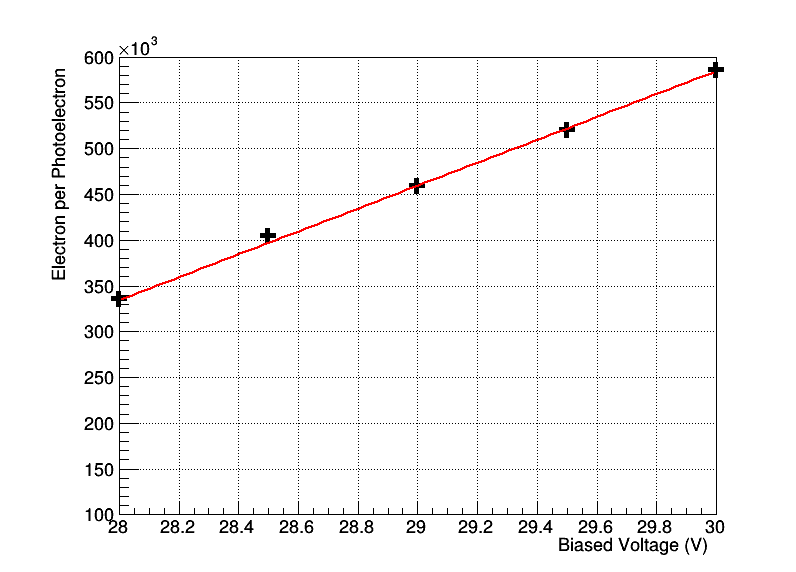

In [36]:
canvas = rt.TCanvas('c_gain', 'c_gain', 800, 600)
legend = rt.TLegend(0.15,0.70,0.35,0.9);
legend_entry = ['J_33_5','J_33_4','J_33_3','J_33_2']
gain.SetTitle("")
gain.GetXaxis().SetTitle('Biased Voltage (V)')
gain.GetYaxis().SetTitle('Electron per Photoelectron')

#apply crosstalk correction
# ham.Apply(rt.TF1("fa1","y/1.29",0,100000))
# sensL.Apply(rt.TF1("fa1","y/1.21",0,100000))

for i in range(len(gain_graph_list)):
    gain_graph_list[i].SetMarkerStyle(34)
    gain_graph_list[i].SetMarkerSize(2)
    gain_graph_list[i].SetMarkerColor(i+1)
    legend.AddEntry(gain_graph_list[i],legend_entry[i])

gain.Draw("AP")
# rt.gStyle.SetOptFit(000002200)
# gain.GetXaxis().SetRangeUser(25,30)
gain.GetYaxis().SetRangeUser(100000,600000)
canvas.SetLeftMargin(0.15)
canvas.SetGrid()
canvas.Draw()

# legend.Draw()


for i in range(len(path_list)):
    r = gain_graph_list[i].Fit('pol1', 'S')
    r = r.Get()

    print 'p-val = {:.3f}'.format(r.Prob())

    V_bd = -r.Parameter(0)/r.Parameter(1)
    V_bd_error = ((r.ParError(1)/r.Parameter(1))**2+(r.ParError(0)/r.Parameter(0))**2)**0.5*V_bd
    print ('break down voltage is',V_bd)
    print ('break down voltage uncertainty is',V_bd_error)



In [7]:
canvas = rt.TCanvas('c_xtalk', 'c_xtalk', 800, 600)
legend = rt.TLegend(0.15,0.70,0.55,0.9);
legend_entry = ['J_33_5','J_33_4','J_33_3','J_33_2']
xtalk.SetTitle("")
xtalk.GetXaxis().SetTitle('Biased Voltage (V)')
xtalk.GetYaxis().SetTitle('Total Crosstalk Probability (%)')

#apply crosstalk correction
# ham.Apply(rt.TF1("fa1","y/1.29",0,100000))
# sensL.Apply(rt.TF1("fa1","y/1.21",0,100000))

for i in range(len(gain_graph_list)):
    xtalk_graph_list[i].SetMarkerStyle(34)
    xtalk_graph_list[i].SetMarkerSize(2)
    xtalk_graph_list[i].SetMarkerColor(i+1)
    legend.AddEntry(xtalk_graph_list[i], "Measured crosstalk probability")
legend.AddEntry(sensL, "Crosstalk probability from SensL data sheet")
legend.SetTextSize(0.022)


xtalk.Draw("AP")
# rt.gStyle.SetOptFit(000002200)
# gain.GetXaxis().SetRangeUser(25,30)
xtalk.GetYaxis().SetRangeUser(0,35)
canvas.SetLeftMargin(0.15)
canvas.SetGrid()
canvas.Draw()

legend.Draw()

# for i in range(len(path_list)):
#     r = xtalk_graph_list[i].Fit('pol1', 'S')
#     r = r.Get()

#     print 'p-val = {:.3f}'.format(r.Prob())

#     V_bd = -r.Parameter(0)/r.Parameter(1)
#     V_bd_error = ((r.ParError(1)/r.Parameter(1))**2+(r.ParError(0)/r.Parameter(0))**2)**0.5*V_bd
#     print ('break down voltage is',V_bd)
#     print ('break down voltage uncertainty is',V_bd_error)






NameError: name 'sensL' is not defined